In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
from astropy.table import Table, vstack, join
from Ska.Matplotlib import plot_cxctime
import cPickle
from Ska.engarchive import fetch
from kadi import events
from Chandra.Time import DateTime
from Ska.Numpy import interpolate
import os
from itertools import izip

Read in sources from table file

In [4]:
srcs = Table.read('src_table.dat', format='ascii')
used = (srcs['NET_COUNTS'] > 2500) & (srcs['point_source'] == 'True')
srcs = srcs[used]

In [5]:
resid_obsids = srcs[(srcs['kalman_tstop'] - srcs['kalman_tstart']) > 10000]['obsid']
BIN = 10000.
DATADIR = 'auto'
AX = 'yag'

In [6]:
GRADIENTS = dict(OOBAGRD3=dict(yag=6.98145650e-04,
                                zag=9.51578351e-05),
                OOBAGRD6=dict(yag=-1.67009240e-03,
                                zag=-2.79084775e-03))

In [7]:
def binned_mean(data, evtstime, tbin=1000.):
    """
    bin data in time bins of tbin size using evtstime as time data
    
    :param data: data to bin as array or numpy array
    :param evtstime: times associated with data
    :param tbin: bin time in units that match evtstime (generally seconds)
    :returns: [bin times,
                data mean for time bin,
                data std of bin]
    """
    ts = []
    ds = []
    ds_std = []
    for win_start in range(0,
                           int(evtstime[-1]-evtstime[0])-int(tbin),
                           int(tbin)):
        tmask = ((evtstime-evtstime[0] >= win_start)
                 & (evtstime-evtstime[0] < win_start + int(tbin)))
        range_data = data[ tmask ]
        range_time = evtstime[ tmask ]
        if np.std(range_data) > 0:
            ds.append(np.mean(range_data))
            ds_std.append(np.std(range_data)/np.sqrt(len(range_data)))
            #t = np.mean(range_time)
            t = (np.max(range_time) + np.min(range_time))/2.
            ts.append(t)
    return [ts, ds, ds_std]

In [8]:
def per_obs_binned_data(obs):
    """
    Fetch X-ray position and gradient telemetry for a given observation,
    bin it by time, and return a brief table (astropy Table) of useful values where each row
    corresponds to a bin time slice.  This table includes:
    
    time (bin mean time),
    yag, y_std, yag_mean (for whole observation not the bin),
    zag, z_std, zag_mean (for whole observation not the bin),
    oobagrd3, oobagrd3_mean (for observation),
    oobagrd6, oobagrd6_mean (for observation),
    ohrthr42, ohrthr42_mean (for observation),
    obsid
    
    The "mean" and obsid cols are fixed per observation, and are just conveniences to work with the
    time binned data
            """
    obsdir = os.path.join(DATADIR, 'obs{:05d}'.format(obs))
    pos_data = cPickle.load(open(os.path.join(obsdir, 'pos.pkl')))
    tilt = cPickle.load(open(os.path.join(obsdir, 'tilt.pkl')))
    ts, yag, yag_std = binned_mean(pos_data['yag'], pos_data['time'], BIN)
    ts, zag, zag_std = binned_mean(pos_data['zag'], pos_data['time'], BIN)
    obs_chunk = {'time': ts, 'yag': yag, 'yag_std': yag_std, 'zag': zag, 'zag_std': zag_std}
    obs_chunk['yag_mean'] = np.repeat(np.mean(pos_data['yag']), len(ts))
    obs_chunk['zag_mean'] = np.repeat(np.mean(pos_data['zag']), len(ts))
    for msid in ['oobagrd3', 'oobagrd6', 'ohrthr42']:
        obs_chunk[msid] = interpolate(tilt[msid.upper()].vals, tilt[msid.upper()].times, ts)
        ok_time = ((tilt[msid.upper()].times > pos_data['time'][0]) &
                   (tilt[msid.upper()].times < pos_data['time'][-1]))
        obs_chunk['{}_mean'.format(msid)] = np.repeat(np.mean(tilt[msid.upper()].vals[ok_time]), len(ts))
    obs_chunk['obsid'] = np.repeat(obs, len(ts)).tolist()
    return Table(obs_chunk)

In [9]:
def get_all_bins(resid_obsids):
    """
    Get binned data for all requested obsids and make one big astropy table.  
    See per_obs_binned_data for a brief description of table columns
    """
    bin_data = None
    for obsid in resid_obsids:
        odata = per_obs_binned_data(obsid)
        if bin_data is None:
            bin_data = odata
        else:
            bin_data = vstack([bin_data, odata])
    return bin_data

In [10]:
def get_obs_col_p2p(obsid, col, table):
    """
    Given an astropy table from get_all_bins, a specific obsid, and a requested column, return the
    min and max values of the column during the obsid.
    """
    obs_data = table[table['obsid'] == obsid]
    return {col: np.max(obs_data[col]) - np.min(obs_data[col]), 'obsid': obsid, 'time': obs_data[0]['time']}

In [11]:
def tilt_model(tilt):
    """
    Define a model for the periscope based on three MSIDS.  The tilt telemetry should be passed
    as columns in an astropy Table.  
    The MSIDs were already interpolated when the binned MSIDs were made in the standard use of 
    calling this on data from get_all_bins().
    Returns model function.
    """
    ax = tilt['oobagrd3'].data
    di = tilt['oobagrd6'].data
    bulk = tilt['ohrthr42'].data
    ax_mean = tilt['oobagrd3_mean'].data
    di_mean = tilt['oobagrd6_mean'].data
    bulk_mean = tilt['ohrthr42_mean'].data
    def model(pars, x):
        m = (pars[0]*3600*(ax+pars[3]) +
             pars[1]*3600*(di+pars[4]) +
             pars[2]*3600*(bulk+pars[5]))
        m_mean = (pars[0]*3600*(ax_mean+pars[3]) +
                  pars[1]*3600*(di_mean+pars[4]) +
                  pars[2]*3600*(bulk_mean+pars[5]))
        return (m - m_mean)
    return model

In [12]:
bin_data = get_all_bins(resid_obsids)
cPickle.dump(bin_data, open('bin_data.pkl', 'w'))
if not os.path.exists('bin_data.pkl'):
    bin_data = get_all_bins(resid_obsids)
    cPickle.dump(bin_data, open('bin_data.pkl', 'w'))
else:
    bin_data = cPickle.load(open('bin_data.pkl'))

In [13]:
model = tilt_model(bin_data)

In [14]:
bin_data['2010_model'] = model([GRADIENTS['OOBAGRD3'][AX], GRADIENTS['OOBAGRD6'][AX], 0, 0, 0, 0],
                                   bin_data['time'])

In [15]:
bin_data['new_model'] = model([0.00055, 0, 0, 0, 0, 0], bin_data['time'])

In [16]:
p2p = Table([get_obs_col_p2p(obsid, AX, bin_data) for obsid in resid_obsids])
p2p_2010_model = Table([get_obs_col_p2p(obsid, '2010_model', bin_data) for obsid in resid_obsids])
p2p_new_model = Table([get_obs_col_p2p(obsid, 'new_model', bin_data) for obsid in resid_obsids])
p2p = join(p2p, p2p_2010_model)
p2p = join(p2p, p2p_new_model)

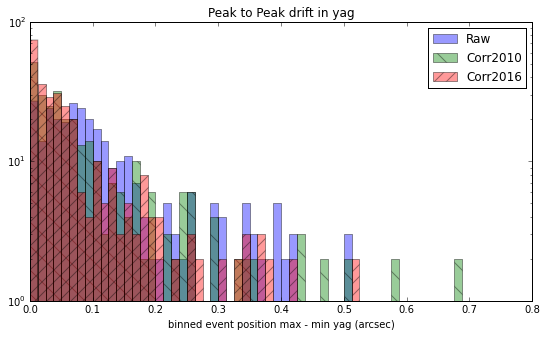

In [17]:
figure(figsize(9,5))
bins = np.arange(0, 0.8, 0.0125)
hist(p2p[AX], bins=bins, color='blue', alpha=.4, hatch='', log=True, label='Raw');
hist(p2p['2010_model'], bins=bins, color='green', alpha=.4, hatch='\\', log=True, label='Corr2010');
hist(p2p['new_model'], bins=bins, color='red', alpha=.4, hatch='//', log=True, label='Corr2016');
title('Peak to Peak drift in {}'.format(AX));
xlabel('binned event position max - min {} (arcsec)'.format(AX))
legend();

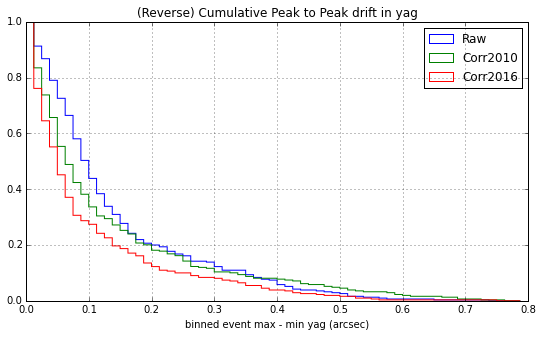

In [18]:
figure(figsize(9,5))
bins = np.arange(0, 0.8, 0.0125)
p2p_hist = hist(p2p[AX], bins=bins, color='blue', histtype='step', cumulative=-1, normed=True, label='Raw');
p2p_2010_hist = hist(p2p['2010_model'], bins=bins, color='green', histtype='step', cumulative=-1, 
                     normed=True, label='Corr2010');
p2p_new_hist = hist(p2p['new_model'], bins=bins, color='red', histtype='step', cumulative=-1,
                    normed=True, label='Corr2016');
grid()
ylim(0, 1.0)
title('(Reverse) Cumulative Peak to Peak drift in {}'.format(AX));
xlabel('binned event max - min {} (arcsec)'.format(AX))
legend();

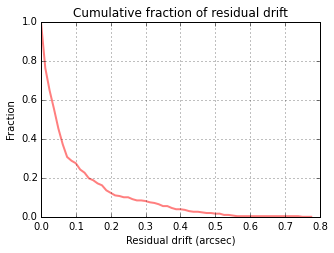

In [19]:
figure(figsize(5, 3.5))
#plot(p2p_hist[1][:-1], p2p_hist[0], label='Raw', alpha=0.5, color='blue', linewidth=2)
#plot(p2p_2010_hist[1][:-1], p2p_2010_hist[0], label='Corr2010')
plot(p2p_new_hist[1][:-1], p2p_new_hist[0], label='Corr2016', color='red', alpha=0.5, linewidth=2)
grid()
ylim(0, 1.0)
title('Cumulative fraction of residual drift');
xlabel('Residual drift (arcsec)')
ylabel('Fraction')

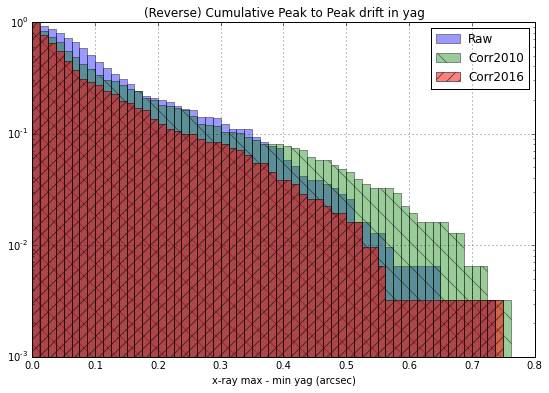

In [20]:
figure(figsize(9,6))
bins = np.arange(0, 0.8, 0.0125)
hist(p2p[AX], bins=bins, color='blue', alpha=.4, log=True, cumulative=-1, normed=True, label='Raw');
hist(p2p['2010_model'], bins=bins, color='green', alpha=.4, hatch='\\', log=True, cumulative=-1,
     normed=True, label='Corr2010');
hist(p2p['new_model'], bins=bins, color='red', alpha=.5, hatch='//', log=True, cumulative=-1,
     normed=True, label='Corr2016');
grid();
title('(Reverse) Cumulative Peak to Peak drift in {}'.format(AX));
xlabel('x-ray max - min {} (arcsec)'.format(AX))
legend();

In [21]:
# borrow percentile group/select from aimpoint_mon code
p2p['year'] = DateTime(p2p['time']).frac_year
p2p['time_bin'] = np.trunc(p2p['year'])
t_bin = p2p.group_by('time_bin')
i_sorts = t_bin.groups.aggregate(np.argsort)
perc_select = {}
for col in AX, '2010_model', 'new_model':
    for perc in (50, 90, -5):
        rows = []
        for group, i_sort in izip(t_bin.groups, i_sorts[col]):
            if perc < 0:
                for row in group[i_sort[perc:]]:
                    rows.append(row)
            else:
                ii = (int(perc) * (len(group) - 1)) // 100
                rows.append(group[i_sort[ii]])
        perc_select[str(perc) + '_' + col] = Table(rows=rows, names=t_bin.colnames)

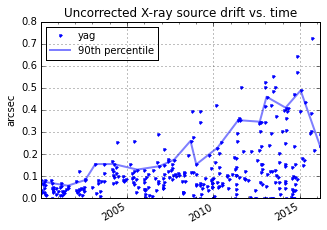

In [39]:
figure(figsize(5, 3.5))
col='yag'
color='blue'
plot_cxctime(p2p['time'], p2p[col], marker='.', color=color, linestyle='', label=col);
plot_cxctime(perc_select['90_' + col]['time'], perc_select['90_' + col][col], color=color,
             label='90th percentile', alpha=.5, linewidth=2)
grid()
title("Uncorrected X-ray source drift vs. time")
ylabel('arcsec')
legend(numpoints=1, loc='upper left', fontsize=10)

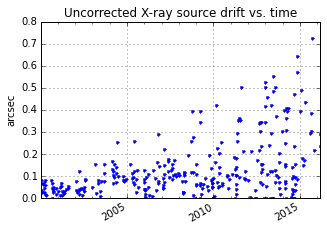

In [40]:
figure(figsize(5, 3.5))
col='yag'
color='blue'
plot_cxctime(p2p['time'], p2p[col], marker='.', color=color, linestyle='', label=col);
#plot_cxctime(perc_select['90_' + col]['time'], perc_select['90_' + col][col], color=color,
#             label='90th percentile', alpha=.5, linewidth=2)
grid()
title("Uncorrected X-ray source drift vs. time")
ylabel('arcsec')
#legend(numpoints=1, loc='upper left', fontsize=10)

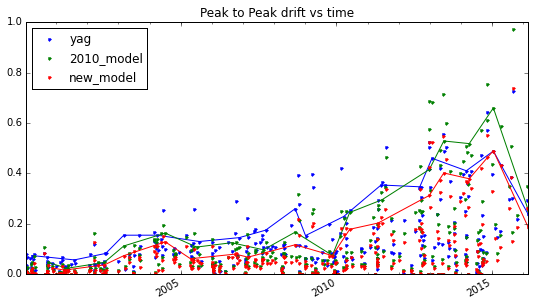

In [22]:
figure(figsize(9, 5))
for col, color in izip([AX, '2010_model', 'new_model'], ['b', 'g', 'r']):
    plot_cxctime(p2p['time'], p2p[col], marker='.', color=color, linestyle='', label=col);
    plot_cxctime(perc_select['90_' + col]['time'], perc_select['90_' + col][col], color=color)
title("Peak to Peak drift vs time")
legend(numpoints=1, loc='upper left')

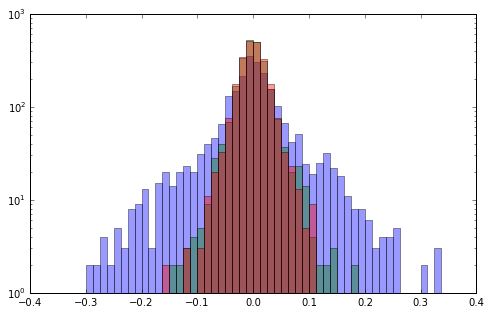

In [23]:
figure(figsize(8, 5))
bins = np.arange(-0.4, 0.4, .0125)
hist(bin_data[AX] - bin_data['{}_mean'.format(AX)], bins=bins, color='blue', alpha=.4, log=True);
hist(bin_data[AX] - bin_data['{}_mean'.format(AX)] - bin_data['2010_model'], bins=bins, log=True, color='green', alpha=.4);
hist(bin_data[AX] - bin_data['{}_mean'.format(AX)] - bin_data['new_model'], bins=bins, log=True, color='red', alpha=.4);


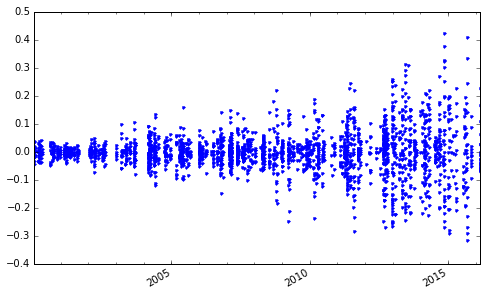

In [24]:
figure()
plot_cxctime(bin_data['time'], bin_data['yag'] - bin_data['yag_mean'], 'b.');

In [25]:
def resid_plot(obsid):
    src = srcs[srcs['obsid'] == obsid]
    print src[['obsid', 'kalman_datestart', 'detector', 'grating']]
    figure(figsize=(5, 3.5))
    #ax1 = fig.add_axes([0, .33, .75, .75])
    obs_data = bin_data[bin_data['obsid'] == obsid]
    times = (obs_data['time'] - np.min(obs_data['time']))/1000.
    errorbar(times,
             obs_data[AX] - obs_data['{}_mean'.format(AX)],
             yerr=obs_data['{}_std'.format(AX)],
             linestyle='',
            label='X-ray source centroid')
    #plot(times, obs_data['2010_model'], color='green')
    plot(times, obs_data['new_model'], color='red', label='Model correction', linewidth=2, alpha=.5)
    grid()
    ylim(-0.3, 0.3)
    xlim(-10, 160)
    title('X-ray drift and model correction')
    xlabel("Time (ksec)")
    ylabel("Offset from mean (arcsec)")
    legend(numpoints=1, fontsize=8)
    #title('Obsid {} {} offsets'.format(obsid, AX))
    #title('Obsid {} {} offsets\n2010 model(green), testing model(red)'.format(obsid, AX))
    #ylabel('{} offset from mean event position (arcsec)'.format(AX))
    #resid = (obs_data[AX] - obs_data['{}_mean'.format(AX)]) - obs_data['new_model']
    #ax2 = fig.add_axes([0, 0, .75, .33], sharex=ax1)
    #plot(times, resid, color='red')
    #ylabel('bin data - model')
    #xlabel('Observation time (ksec)')
    #grid()
    #xlim(-10, 150);
    #ylim(-.4, .4);
    #plt.setp(ax1.get_xticklabels(), visible=False);
    #plt.setp(ax1.get_yticklabels()[0], visible=False);


obsid    kalman_datestart   detector grating
----- --------------------- -------- -------
14534 2013:123:04:49:38.540   ACIS-S    HETG


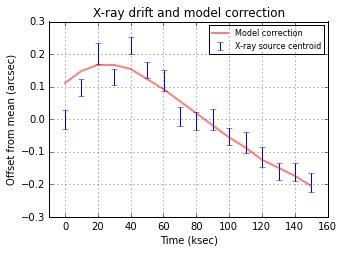

In [26]:
#for obsid in [4820, 14457, 17105, 17128, 12916, 14534, 16313, 16311]:
#    resid_plot(obsid)

resid_plot(14534)


obsid    kalman_datestart   detector grating
----- --------------------- -------- -------
16313 2014:096:19:00:42.741    HRC-S    LETG


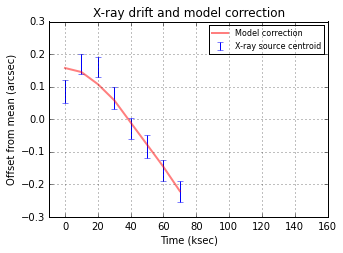

In [27]:
resid_plot(16313)

obsid    kalman_datestart   detector grating
----- --------------------- -------- -------
14534 2013:123:04:49:38.540   ACIS-S    HETG


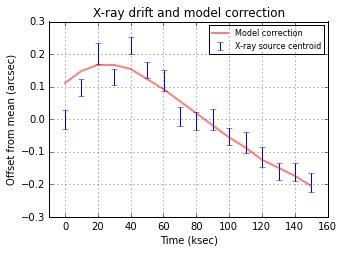

In [28]:
resid_plot(14534)

obsid    kalman_datestart   detector grating
----- --------------------- -------- -------
13900 2012:275:10:14:47.544   ACIS-S    NONE


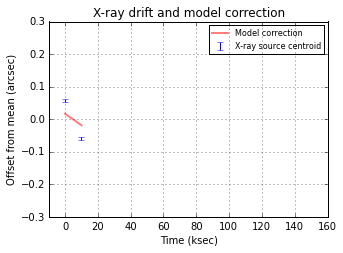

In [29]:
resid_plot(13900)

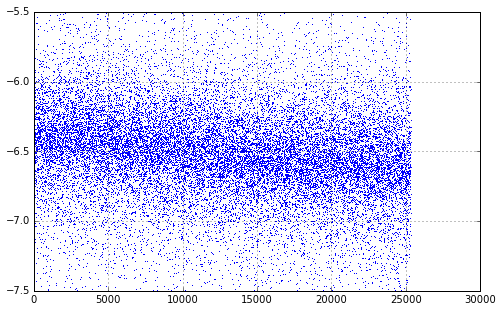

In [30]:
obs = 13900
obsdir = os.path.join(DATADIR, 'obs{:05d}'.format(obs))
tilt = cPickle.load(open(os.path.join(obsdir, 'tilt.pkl')))
pos_data = cPickle.load(open(os.path.join(obsdir, 'pos.pkl')))
figure()
plot(pos_data['yag'], ',')
ylim(-7.5, -5.5)
grid()